In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib widget
import matplotlib.pyplot as plt
from ipywidgets import *
import numpy as np
import k3d
import matplotlib.pyplot as plt
from sloppy.optic import *
from sloppy.raytracing import *
from sloppy.abcd import *
from sloppy.utils import *
from sloppy.tools import *

In [3]:
a = 4.0
b = 3.0
R = 4.0

x, y = -2.9, -4.1

In [4]:
_x = np.linspace(-3*a,3*a,120)
x, y = np.meshgrid(_x, _x, indexing='ij')

In [5]:
x.flatten()

array([-12., -12., -12., ...,  12.,  12.,  12.])

In [6]:
x_idx = np.floor(x/a+0.5)
x_mod = x-a*x_idx
y_idx = np.floor(y/b+0.5)
y_mod = y-b*y_idx
# x_idx, x_mod = np.divmod(x-0.5*a,a)
# y_idx, y_mod = np.divmod(y-0.5*b,b)

# x_idx, x_mod

In [7]:
x_idx, x_mod

(array([[-3., -3., -3., ..., -3., -3., -3.],
        [-3., -3., -3., ..., -3., -3., -3.],
        [-3., -3., -3., ..., -3., -3., -3.],
        ...,
        [ 3.,  3.,  3., ...,  3.,  3.,  3.],
        [ 3.,  3.,  3., ...,  3.,  3.,  3.],
        [ 3.,  3.,  3., ...,  3.,  3.,  3.]]),
 array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.20168067,  0.20168067,  0.20168067, ...,  0.20168067,
          0.20168067,  0.20168067],
        [ 0.40336134,  0.40336134,  0.40336134, ...,  0.40336134,
          0.40336134,  0.40336134],
        ...,
        [-0.40336134, -0.40336134, -0.40336134, ..., -0.40336134,
         -0.40336134, -0.40336134],
        [-0.20168067, -0.20168067, -0.20168067, ..., -0.20168067,
         -0.20168067, -0.20168067],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]]))

In [8]:
cpx = a*x_idx
cpy = b*y_idx

In [9]:
r_mod = np.sqrt(x_mod**2+y_mod**2)

In [10]:
z = R - np.sqrt(R**2-r_mod**2)

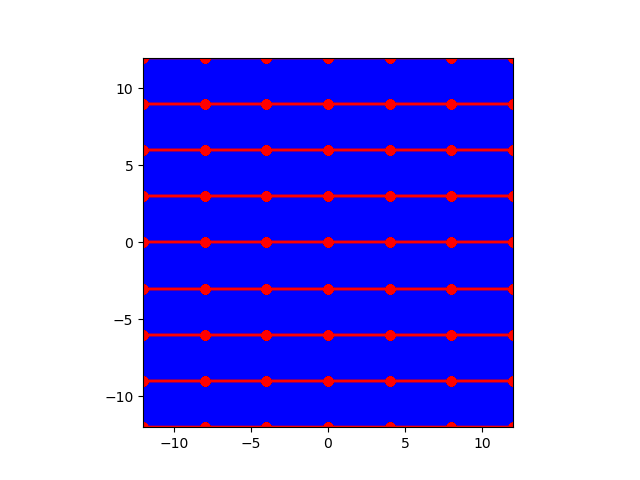

In [11]:
plt.figure()
plt.imshow(-z.T, origin='lower', extent=[_x[0], _x[-1], _x[0], _x[-1]])
plt.plot(x, y, 'blue', marker='o')
plt.plot(cpx, cpy, 'red', marker='o')

In [12]:
def LensCavAsph(flong=100.0, eps_grin=0.0, eps_long=-4.0, eps_mirr=-4.0, lens_diam=25.4, grin_diam=2.4, grin_thick=1.5, lens_thick=6.0):
    
    fgrin=1.5
    
    p_grin_f = fgrin + eps_grin
    p_grin_b = p_grin_f + grin_thick
    p_long_f = p_grin_b + fgrin + flong + eps_long
    p_long_b = p_long_f + lens_thick
    p_mirr = p_long_b + flong + eps_mirr
    
    p0 = np.array([0,0,p_grin_f])
    p1 = np.array([0,0,p_grin_b])
    p2 = np.array([0,0,p_long_f])
    p3 = np.array([0,0,p_long_b])
    p4 = np.array([0,0,p_mirr])

    e = np.array([0,0,5.0])*0
    
    pm0 = np.array([0,0,-p_grin_f])
    pm1 = np.array([0,0,-p_grin_b])
    pm2 = np.array([0,0,-p_long_f])
    pm3 = np.array([0,0,-p_long_b])
    pm4 = np.array([0,0,-p_mirr])

    
    
    ii = lens_diam
    hi = 12.7
    qi=7.75
    ng = 1.4537

    # Rgrin = (ng-1)*fgrin
    Rlong = (ng-1)*flong
    # now C140 instead of "spherical" GRIN lens
    Rgrin = -0.840660
    k=-0.963070
    An=[-9.476566e-2, -2.790461e-2, -5.415580e-3, -3.553653e-3]
    
    coeff = np.array([Rgrin, k,] + An) #these coefficients go _away_ from the normal
    coeffm = coeff*-1 #these coefficients go _to_ the normal
    coeffm[1] = k
    
    nz = (0., 0. ,-1.0)
    nzm = (0., 0. ,1.0)
    axz = (-1, 0, 0)
    axzm = (1, 0, 0)

    screen = Screen(n=nzm, ax=axzm)
    
    # negative sign of first cuved surface for abcd matrix
    elements = [screen,
                Glass(p=p0, n=nz, ax=axz, diameter=grin_diam, n2=ng),
                #CurvedGlass(p=p1, n=nz, ax=axz, diameter=grin_diam, R=-Rgrin, curv='CC', n1=ng),
                ThorlabsAsphere(p=p1, n=nz, ax=axz, diameter=grin_diam, R=Rgrin, n1=ng, coef=coeffm), #R=-Rgrin,
                Glass(p=p2, n=nz, ax=axz, diameter=ii, n2=ng),
                CurvedGlass(p=p3, n=nz, ax=axz, diameter=ii, R=-Rlong, curv='CC', n1=ng),
                Mirror(p=p4, n=nz, ax=axz, diameter=ii),
                #backwards pass
                CurvedGlass(p=p3+e, n=nzm, ax=axzm, diameter=ii, R=Rlong, curv='CX', n2=ng),
                Glass(p=p2+e, n=nzm, ax=axzm, diameter=ii, n1=ng),
                #CurvedGlass(p=p1+e, n=nzm, ax=axzm, diameter=grin_diam, R=Rgrin, curv='CX', n2=ng),
                ThorlabsAsphere(p=p1+e, n=nzm, ax=axzm, diameter=grin_diam, R=-Rgrin, n2=ng, coef=coeff), #R=-Rgrin,
                Glass(p=p0+e, n=nzm, ax=axzm, diameter=grin_diam, n1=ng),
                #left half
                Glass(p=pm0, n=nzm, ax=axzm, diameter=grin_diam, n2=ng),
                #CurvedGlass(p=pm1, n=nzm, ax=axzm, diameter=grin_diam, R=-Rgrin, curv='CC', n1=ng),
                ThorlabsAsphere(p=pm1, n=nzm, ax=axzm, diameter=grin_diam, R=Rgrin, n1=ng, coef=coeffm),
                Glass(p=pm2, n=nzm, ax=axzm, diameter=ii, n2=ng),
                CurvedGlass(p=pm3, n=nzm, ax=axzm, diameter=ii, R=-Rlong, curv='CC', n1=ng),
                Mirror(p=pm4, n=nzm, ax=axzm, diameter=ii),
                #backwards pass
                CurvedGlass(p=pm3+e, n=nz, ax=axz, diameter=ii, R=Rlong, curv='CX', n2=ng),
                Glass(p=pm2+e, n=nz, ax=axz, diameter=ii, n1=ng),
                #CurvedGlass(p=pm1+e, n=nz, ax=axz, diameter=grin_diam, R=Rgrin, curv='CX', n2=ng),
                ThorlabsAsphere(p=pm1+e, n=nz, ax=axz, diameter=grin_diam, R=-Rgrin, n2=ng, coef=coeff),
                Glass(p=pm0+e, n=nz, ax=axz, diameter=grin_diam, n1=ng),]

    return elements

In [13]:
elements = LensCavAsph(eps_grin=0.0, eps_long=-5.0)
screen = elements[0]
sys = RaySystem(elements, add_screen=False)
sys.screen = screen

# mu = np.array([0.5, 0., 0., 0.])
# mu = np.stack([[0.0, 0., sx, 0.] for sx in np.linspace(-0.1, 0.1, 7)], axis=0)
mu = np.stack([[xx, 0., 0., 0.] for xx in np.linspace(-0.1, 0.1, 7)*0.1], axis=0)


ray = sys.screen.eigenvectors_to_rays(mu)

TypeError: ThorlabsAsphere.__init__() got an unexpected keyword argument 'R'

In [ ]:
traj = sys.propagate(ray, at_screen=False, clip=False)

In [ ]:
plt.figure(figsize=(12, 3))
for i in range(traj.shape[2]):
    plt.plot(traj[:, 0, i, 2], traj[:, 0, i, 0])
plt.show()

In [ ]:
try:
    plot.close()
except:
    pass
plot = k3d.plot(camera_auto_fit=True, antialias=True)

for i, el in enumerate(sys.elements):
    if not isinstance(el, Screen):
        plot += el.plot(opacity=0.4)

for i, el in enumerate(sys.elements):
    plot_element_ax(el, plot, length=2.)

# # plot_rays(ray, plot)
plot_trajs(traj[0:7], plot)
plot_trajs(traj[6:], plot, color=0x555500)

plot.display()

In [9]:
cavfct = LensCav
parname = 'eps_grin'
res = degeneracy_length(cavfct, parname, 1)
Ldeg = res.x
print(res)
elements = cavfct(**{parname: Ldeg})
sys = RaySystem(elements)
system = sys.abcd
mu1, mu2 = system.q

UnboundLocalError: local variable 'fu' referenced before assignment

In [74]:
def _cavity_parameter_interaction_factory(cavfct, parname, scanrange, N = 300):
    fig, ax = plt.subplots(ncols=2, figsize=(8,4), sharex=True)
    lws = [ax[0].plot([0, 1], [0, 1])[0] for i in range(2)]
    ax[0].set_ylabel('um')
    lfs = [ax[1].plot([0, 1], [0, 1])[0] for i in range(4)]
    ax[1].set_ylabel('MHz')
    axh1 = ax[1].axhline(0, color='grey')
    axv0 = ax[0].axvline(0, color='grey')
    axv1 = ax[1].axvline(0, color='grey')
    plt.show()
    
    def update_waists_vs_params(cavfct, parname, scanrange, N = 300, **kwargs):
        stab = lambda m: abs(0.5*np.trace(m))<1
        scanrange=[-5, 3]
        La = kwargs[parname]
        Las = La + np.linspace(-scanrange[0], scanrange[0], N)
        ms = np.zeros((N))
        ws = np.zeros((N,2))
        freqs = np.zeros((N,4))
        for i, l in enumerate(Las):
            pardct = kwargs.copy()
            pardct.update({parname: l})
            sys = RaySystem( cavfct(**pardct) )

            try:
                system = sys.abcd
                w = system.waist_at(0)
            except:
                ws[i,:] = np.nan
                ms[i] = np.nan
                freqs[i,...] = np.nan
            else:
                ms[i] = stab(system.abcd_rt)
                ws[i,:] = np.sort(w)
                freqs[i,...] = np.concatenate(system.get_freqs(s=1))
                #ft, fs3 = system.get_freqs()
                #fsr = system.fsr
                #freqs[i,...] = np.concatenate((ft, np.mod(3*ft, fsr)))
                idx = np.argmin(np.abs(freqs[:,2]))
        for i in range(2):
            lws[i].set_data(np.stack((Las, ws[:,i]*1e3), axis=0))
        for i in range(4):
            lfs[i].set_data(np.stack((Las, freqs[:,i]*1e-6), axis=0))
        axv0.set_xdata([Las[idx], Las[idx]])
        axv1.set_xdata([Las[idx], Las[idx]])
        Ldeg = Las[idx]
        ax[0].set_xlim(Las[0], Las[-1])
        ax[0].set_ylim(0.8*np.nanmin(ws*1e3), 1.1*np.nanmax(ws*1e3))
        ax[1].set_ylim(0.8*np.nanmin(freqs*1e-6), 1.1*np.nanmax(freqs*1e-6))
        fig.canvas.draw_idle()
    
    _magnitude = lambda x: 1. if abs(x)<0.1 else int(np.floor(np.log10(abs(x))))
    _sgn = lambda x: 1 if x>0 else -1
    _min = lambda x: 1.5*x if x<0 else 0.5*x
    _max = lambda x: 0.5*x if x<0 else 1.5*x

    
    lo = Layout(width='80%', height='30px')
    for v in inspect.signature(cavfct).parameters.values():
        print(v.name, v.default)
    sliders = {v.name: FloatSlider(value=v.default, min=_min(v.default), max=_max(v.default), step=10**(_magnitude(v.default)-2), readout_format='.2e', layout=lo) for v in inspect.signature(cavfct).parameters.values()}
    sliders.update({'scanrange': FloatLogSlider(value=scanrange, min=-3, max=1, step=0.5, layout=lo)})
    return interactive(update_waists_vs_params, cavfct=fixed(cavfct), parname = fixed('eps_grin'), N=fixed(N), **sliders)

In [76]:
_cavity_parameter_interaction_factory(LensCavAsph, 'eps_grin',0.1, N=100)

C:\Users\lukas\.conda\envs\sloppy\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

flong 100.0
eps_grin 0.0
eps_long -4.0
eps_mirr -4.0
lens_diam 25.4
grin_diam 2.4
grin_thick 1.5
lens_thick 6.0


interactive(children=(FloatLogSlider(value=0.1, description='scanrange', layout=Layout(height='30px', width='8…

In [77]:
cavfct = LensCav
elements = cavfct(eps_long=-4.2, eps_grin=-1.3)
sys = RaySystem(elements)
system = sys.abcd
mu1, mu2 = system.q

In [80]:
x = np.linspace(0, system.Ltot, 5000)
ws = system.compute_waists(x)
plt.figure()
plt.plot(x, ws)
# plt.yscale('log')
plt.show()

C:\Users\lukas\.conda\envs\sloppy\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [302]:
plt.close('all')

In [5]:
Npt = 20
a = 0.5
x = np.linspace(-a, a, Npt)
coords = np.meshgrid(x, x)

xy = np.stack(coords, axis=-1).reshape((-1,2))
#pxy = np.zeros_like(xy)
pxy = np.broadcast_to(np.array([0, 0]), xy.shape)
mu = np.concatenate((xy, pxy), axis=1)
ray = sys.screen.eigenvectors_to_rays(mu)

In [6]:
traj = sys.propagate(ray, at_screen=True)
pos = sys.screen.r_to_screen_coords(traj[-1,0,:,:])

In [7]:
plt.figure()
plt.scatter(xy[:,0], xy[:,1], s=2.)
plt.scatter(pos[:,0], pos[:,1], s=2.)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [10]:
fig, ax = plt.subplots(ncols=1, figsize=(6, 6))
ms = 8.
linea = plt.scatter(xy[:,0], xy[:,1], s=2.)
lineb = plt.scatter(pos[:,0], pos[:,1], s=2.)
plt.xlabel('x [mm]')
plt.ylabel('y [mm]')

cavfct = LensCav
parname = 'lens_dist'

def update_xygrid(dl=0.0, a=0.1, px=1e-2, py=-1e-3, Nrt=3, Npts=20, **kwargs):
    res = degeneracy_length(cavfct, parname, 1e-3)
    Ldeg = res.x
    print(res)
    elements = cavfct(**{parname: Ldeg+dl})
    sys = RaySystem(elements)
    
    x = np.linspace(-a, a, Npts)
    coords = np.meshgrid(x, x)
    xy = np.stack(coords, axis=-1).reshape((-1,2))
    pxy = np.broadcast_to(np.array([px, -py]), xy.shape)
    mu = np.concatenate((xy, pxy), axis=1)
    ray = sys.screen.eigenvectors_to_rays(mu)
    traj = sys.propagate(ray, at_screen=True)
    pos = sys.screen.r_to_screen_coords(traj[-1,0,:,:])
    linea.set_offsets(xy)
    lineb.set_offsets(pos)
  
    #ax.relim()
    #ax.autoscale_view()
    fig.canvas.draw_idle()
        
interactive(update_xygrid, dl=(-1, 1, 1e-3), a = (0,1,1e-2),\
            px=(-0.1,0.1,1e-3), py=(-0.1,0.1,1e-3), Nrt=(0,10,1), Npts=(10, 100, 10))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

interactive(children=(FloatSlider(value=0.0, description='dl', max=1.0, min=-1.0, step=0.001), FloatSlider(val…

In [31]:
fig, ax = plt.subplots(ncols=1, figsize=(6, 6))
ms = 8.
linea = plt.scatter(xy[:,0], xy[:,1], s=2.)
lineb = plt.scatter(pos[:,0], pos[:,1], s=2.)
plt.xlabel('px [mm]')
plt.ylabel('py [mm]')

cavfct = LensCav
parname = 'lens_dist'

def update_xygrid(dl=0.0, a=5e-2, x=0.004, y=-0.004, Nrt=3, Npts=20, **kwargs):
    res = degeneracy_length(cavfct, parname, 1e-3)
    Ldeg = res.x
    elements = cavfct(**{parname: Ldeg+dl})
    sys = RaySystem(elements)
    
    xx = np.linspace(-a*1e-1, a*1e-1, Npts)
    coords = np.meshgrid(xx, xx)
    pxy = np.stack(coords, axis=-1).reshape((-1,2))
    xy = np.broadcast_to(np.array([x, y]), pxy.shape)
    mu = np.concatenate((xy, pxy), axis=1)
    ray = sys.screen.eigenvectors_to_rays(mu)
    traj = sys.propagate(ray, Nrt=Nrt, at_screen=True)
    pos = sys.screen.r_to_screen_coords(traj[-1,0,:,:])
    linea.set_offsets(pxy)
    lineb.set_offsets(pos)
    plt.xlim(1.5*np.nanmin(pxy[:,0]), 1.5*np.nanmax(pxy[:,0]))
    plt.ylim(1.5*np.nanmin(pxy[:,1]), 1.5*np.nanmax(pxy[:,1]))
    fig.canvas.draw_idle()
interactive(update_xygrid, dl=(-1, 1, 1e-3), a = (0,1,1e-3),\
            x=(-0.1,0.1,1e-3), y=(-0.1,0.1,1e-3), Nrt=(0,10,1), Npts=(10, 100, 10))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

interactive(children=(FloatSlider(value=0.0, description='dl', max=1.0, min=-1.0, step=0.001), FloatSlider(val…

In [ ]:
res = degeneracy_length(cavfct, parname, 1e-3)
Ldeg = res.x
elements = cavfct(**{parname: Ldeg+dl})
sys = RaySystem(elements)

a = 0.004
pa = 0.006
xx = np.linspace(-a*1e-1, a*1e-1, Npts)
coords = np.meshgrid(xx, xx)
pxy = np.stack(coords, axis=-1).reshape((-1,2))
xy = np.broadcast_to(np.array([x, y]), pxy.shape)
mu = np.concatenate((xy, pxy), axis=1)
ray = sys.screen.eigenvectors_to_rays(mu)
traj = sys.propagate(ray, Nrt=Nrt, at_screen=True)
pos = sys.screen.r_to_screen_coords(traj[-1,0,:,:])
linea.set_offsets(pxy)
lineb.set_offsets(pos)
plt.xlim(1.5*np.nanmin(pxy[:,0]), 1.5*np.nanmax(pxy[:,0]))
plt.ylim(1.5*np.nanmin(pxy[:,1]), 1.5*np.nanmax(pxy[:,1]))

In [35]:
fig, ax = plt.subplots(ncols=1, figsize=(6, 6))
ms = 8.
linea = plt.scatter(xy[:,0], xy[:,1], s=1., marker='.')
lineb = plt.scatter(pos[:,0], pos[:,1], s=2.)
plt.xlabel('x [mm]')
plt.ylabel('y [mm]')

def update_xygrid6(dl=Ldeg, dz=1.5825, a=0.1, px=1e-2, py=-1e-3, Nrt=1, Npts=20, **kwargs):
    elements, _ = SixMirror(dx=dl, dzF=dz)
    sys = RaySystem(elements)
    
    x = np.linspace(-a, a, Npts)
    coords = np.meshgrid(x, x)
    xy = np.stack(coords, axis=-1).reshape((-1,2))
    pxy = np.broadcast_to(np.array([px, -py]), xy.shape)
    mu = np.concatenate((xy, pxy), axis=1)
    ray = sys.screen.eigenvectors_to_rays(mu)
    traj = sys.propagate(ray, at_screen=True, Nrt=Nrt)
    pos = sys.screen.r_to_screen_coords(traj[-1,0,:,:])
    linea.set_offsets(xy)
    lineb.set_offsets(pos)
  
    ax.relim()
    #ax.autoscale_view()
    fig.canvas.draw_idle()
        
interactive(update_xygrid6, dl=(Ldeg-1, Ldeg+1, 1e-2), dz=(0, 1.5825, 1e-2), a = (0,1,1e-2),\
            px=(-0.1,0.1,1e-3), py=(-0.1,0.1,1e-3), Nrt=(1,11,1), Npts=(10, 100, 10))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

interactive(children=(FloatSlider(value=27.768298126226423, description='dl', max=28.768298126226423, min=26.7…

In [29]:
plt.close("all")